**Table of contents**<a id='toc0_'></a>    
- [Imports](#toc1_1_)    
  - [Dataset](#toc1_2_)    
  - [Visualize the data](#toc1_3_)    
- [Transfer Learning](#toc2_)    
  - [Prepare Data](#toc2_1_)    
  - [Features Extraction Method (caching ResNet so faster but no augmentation)](#toc2_2_)    
    - [Define ResNet Model](#toc2_2_1_)    
    - [Extract features from ResNet](#toc2_2_2_)    
    - [New model](#toc2_2_3_)    
    - [Train](#toc2_2_4_)    
  - [Fine-Tuning method (slower but with augmentation)](#toc2_3_)    
    - [Prepare Data](#toc2_3_1_)    
    - [Create model](#toc2_3_2_)    
  - [Tuning Method (unfreeze few layers from ResNet)](#toc2_4_)    
    - [Model](#toc2_4_1_)    
- [Conclusion](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Imports](#toc0_)

In [1]:
import torch
from torch import nn
from torch import Tensor
import torch.optim as optim
from torchvision import models, transforms, datasets
from tqdm import tqdm

torch.cuda.is_available()

True

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import cv2
import shutil

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## <a id='toc1_2_'></a>[Dataset](#toc0_)
For this assignment I chose: https://www.kaggle.com/datasets/imsparsh/flowers-dataset

## <a id='toc1_3_'></a>[Visualize the data](#toc0_)

In [4]:
def plot_accuracy_from_history(*histories, labels=None) -> None:
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots

    for i, history in enumerate(histories):
        epochs = np.arange(1, len(history['accuracy']) + 1)
        
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        
        plt.plot(epochs, acc, color + 'o', label=f'Training accuracy for {label}')
        plt.plot(epochs, val_acc, color, label=f'Validation accuracy for {label}')
    plt.title('Training and validation accuracy')
    
def plot_loss_from_history(*histories, labels=None) -> None:
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots

    for i, history in enumerate(histories):
        epochs = np.arange(1, len(history['loss']) + 1)
        
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        loss = history['loss']
        val_loss = history['val_loss']
        
        plt.plot(epochs, loss, color + 'o', label=f'Training loss for {label}')
        plt.plot(epochs, val_loss, color, label=f'Validation loss for {label}')
    plt.title('Training and validation loss')

# <a id='toc2_'></a>[Transfer Learning](#toc0_)

## <a id='toc2_1_'></a>[Prepare Data](#toc0_)

In [5]:
EPOCHS: int = 60

In [6]:

kaggle_dir = "flowers"
    
processed_dir = kaggle_dir + "/processed"
flowers_dir = processed_dir + ""
base_dir = flowers_dir + "/"

train_dir: str = base_dir + "train/"
train_daisy_dir: str = train_dir + "daisy/"
train_dandelion_dir: str = train_dir + "dandelion/"
train_rose_dir: str = train_dir + "rose/"
train_sunflower_dir: str = train_dir + "sunflower/"
train_tulip_dir: str = train_dir + "tulip/"

validation_dir: str = base_dir + "validation/"
validation_daisy_dir: str = validation_dir + "daisy/"
validation_dandelion_dir: str = validation_dir + "dandelion/"
validation_rose_dir: str = validation_dir + "rose/"
validation_sunflower_dir: str = validation_dir + "sunflower/"
validation_tulip_dir: str = validation_dir + "tulip/"

test_dir: str = base_dir + "test/"
test_daisy_dir: str = test_dir + "daisy/"
test_dandelion_dir: str = test_dir + "dandelion/"
test_rose_dir: str = test_dir + "rose/"
test_sunflower_dir: str = test_dir + "sunflower/"
test_tulip_dir: str = test_dir + "tulip/"

models_dir: str = "models/"

def create_dirs() -> None:
    all_paths: list[str] = [kaggle_dir, processed_dir, flowers_dir,
                            base_dir, train_dir, train_daisy_dir, train_dandelion_dir, train_rose_dir, train_sunflower_dir, train_tulip_dir, validation_dir, validation_daisy_dir, validation_dandelion_dir, validation_rose_dir, validation_sunflower_dir, validation_tulip_dir, test_dir, test_daisy_dir, test_dandelion_dir, test_rose_dir, test_sunflower_dir, test_tulip_dir, models_dir]
    # create dirs if not exist
    for path in all_paths:
        if not os.path.exists(path):
            os.makedirs(path)

def copy_train_images(indices: np.ndarray, animal: str ='cat', dir_type: str ='train') -> None:
    for index in indices:
        src: str = f"{kaggle_dir}/original/train/{animal}.{index}.jpg"
        dst: str = f"{kaggle_dir}/processed/flowers/{dir_type}/{animal}s/{animal}.{index}.jpg"
        shutil.copyfile(src, dst)

def remove_images():
    if os.path.exists(base_dir):
        shutil.rmtree(base_dir, ignore_errors=True)

def copy_all_images(validation_size_ratio = 0.1, test_size_ratio = 0.1) -> None:
    remove_images()

    create_dirs()
    print("Dirs created")
    
    directories: list[str] = os.listdir("kaggle/flowers/original/train")
    
    print("Dirs listed")

    for directory in directories:
        if not os.path.exists(f"{base_dir}train/{directory}"):
            os.makedirs(f"{base_dir}train/{directory}")
        if not os.path.exists(f"{base_dir}validation/{directory}"):
            os.makedirs(f"{base_dir}validation/{directory}")
        if not os.path.exists(f"{base_dir}test/{directory}"):
            os.makedirs(f"{base_dir}test/{directory}")
            
    print("Dirs created")
            
    for directory in directories:
        files = glob.glob(f"kaggle/flowers/original/train/{directory}/*.jpg")
        
        total_size = len(files)
        
        validation_size = int(total_size * validation_size_ratio)
        test_size = int(total_size * test_size_ratio)
        train_size = total_size - validation_size - test_size
        
        np.random.shuffle(files)
        
        train_files = files[:train_size]
        validation_files = files[train_size:train_size + validation_size]
        test_files = files[train_size + validation_size:]
        
        for file in train_files:
            shutil.copy(file, f"{base_dir}train/{directory}/")
        for file in validation_files:
            shutil.copy(file, f"{base_dir}validation/{directory}/")
        for file in test_files:
            shutil.copy(file, f"{base_dir}test/{directory}/")
    
    print("Images copied")

In [7]:
copy_all_images()

Dirs created
Dirs listed
Dirs created
Images copied


In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Define data directories
data_dir: str = 'flowers/processed/'
image_datasets = {x: datasets.ImageFolder(root=data_dir+x, transform=data_transforms[x]) for x in ['train', 'validation', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=20, shuffle=False) for x in ['train', 'validation', 'test']}


In [9]:
COUNT_OF_CLASSES = len(image_datasets['train'].classes)
print(COUNT_OF_CLASSES)

5


## <a id='toc2_2_'></a>[Features Extraction Method (caching ResNet so faster but no augmentation)](#toc0_)

### <a id='toc2_2_1_'></a>[Define ResNet Model](#toc0_)

In [10]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove the final fully connected layer

    def forward(self, x):
        x = self.resnet(x)
        return x

### <a id='toc2_2_2_'></a>[Extract features from ResNet](#toc0_)

In [11]:
def extract_features(model, dataloader, dataset_size) -> tuple[torch.Tensor, torch.Tensor]:
    model.eval()
    features = torch.zeros(dataset_size, 512, 4, 4, device=device)
    labels = torch.zeros(dataset_size, device=device)
    with torch.no_grad():
        for i, (inputs, labels_batch) in enumerate(dataloader):
            inputs = inputs.to(device)  # Move inputs to the same device as the model
            outputs = model(inputs)
            # Reshape or unsqueeze outputs to match the shape of features
            outputs = torch.unsqueeze(torch.unsqueeze(outputs, -1), -1)
            features[i * dataloader.batch_size : (i + 1) * dataloader.batch_size] = outputs
            labels[i * dataloader.batch_size : (i + 1) * dataloader.batch_size] = labels_batch
    return features, labels

In [12]:
resnet_model = ResNetModel().to(device)

train_features, train_labels = extract_features(resnet_model, dataloaders['train'], len(image_datasets['train']))
validation_features, validation_labels = extract_features(resnet_model, dataloaders['validation'], len(image_datasets['validation']))
test_features, test_labels = extract_features(resnet_model, dataloaders['test'], len(image_datasets['test']))

# Reshape
train_features = train_features.view(len(image_datasets['train']), -1)
validation_features = validation_features.view(len(image_datasets['validation']), -1)
test_features = test_features.view(len(image_datasets['test']), -1)

print(train_features.shape)
print(validation_features.shape)
print(test_features.shape)

/home/lenovo/Proj/DeepNeuralNetworks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lenovo/Proj/DeepNeuralNetworks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1831, 8192])
torch.Size([226, 8192])
torch.Size([226, 8192])


In [13]:
train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
validation_dataset = torch.utils.data.TensorDataset(validation_features, validation_labels)
test_dataset = torch.utils.data.TensorDataset(test_features, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=20, shuffle=True)

### <a id='toc2_2_3_'></a>[New model](#toc0_)

In [14]:
class ModelWithExtracted(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(train_features.shape[1], 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, COUNT_OF_CLASSES)
        )

    def forward(self, x):
        x = self.model(x)
        return x

### <a id='toc2_2_4_'></a>[Train](#toc0_)

In [15]:
model1 = ModelWithExtracted().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

def train_model(model, criterion, optimizer) -> None:
    accuracy_history: list = []
    loss_history: list = []
    val_accuracy_history: list = []
    val_loss_history: list = []
    
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in tqdm(train_loader):
            inputs = inputs.to(device)
            labels = labels.long().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels)
        epoch_loss = running_loss / len(image_datasets['train'])
        epoch_acc = running_corrects / len(image_datasets['train'])
        accuracy_history.append(epoch_acc)
        loss_history.append(epoch_loss)
        
        inputs_val, labels_val = next(iter(validation_loader))
        with torch.no_grad():
            model.eval()
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.long().to(device)
            val_outputs = model(inputs_val)
            val_loss = criterion(val_outputs, labels_val)
            val_preds = torch.round(val_outputs)
            val_acc = torch.sum(torch.argmax(val_preds, 1) == labels_val).item() / len(labels_val)
            val_accuracy_history.append(val_acc)
            val_loss_history.append(val_loss)
        
            print(f"Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            print(f"Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    history = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
    }
    return history
        
history1 = train_model(model1, criterion, optimizer)

100%|██████████| 92/92 [00:01<00:00, 61.20it/s] 


Epoch 1/60 Loss: 0.7424 Acc: 0.7406
Validation Loss: 0.4586 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 269.35it/s]


Epoch 2/60 Loss: 0.3749 Acc: 0.8706
Validation Loss: 0.1929 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 283.78it/s]


Epoch 3/60 Loss: 0.3129 Acc: 0.8924
Validation Loss: 0.5485 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 241.71it/s]


Epoch 4/60 Loss: 0.2657 Acc: 0.9028
Validation Loss: 0.4187 Acc: 0.7000


100%|██████████| 92/92 [00:00<00:00, 231.41it/s]


Epoch 5/60 Loss: 0.2038 Acc: 0.9290
Validation Loss: 0.4917 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 241.47it/s]


Epoch 6/60 Loss: 0.2026 Acc: 0.9257
Validation Loss: 0.6062 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 235.92it/s]


Epoch 7/60 Loss: 0.1537 Acc: 0.9476
Validation Loss: 0.4742 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 238.77it/s]


Epoch 8/60 Loss: 0.1252 Acc: 0.9563
Validation Loss: 0.1066 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 224.46it/s]


Epoch 9/60 Loss: 0.1020 Acc: 0.9645
Validation Loss: 0.7283 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 215.36it/s]


Epoch 10/60 Loss: 0.0588 Acc: 0.9825
Validation Loss: 0.4455 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 225.07it/s]


Epoch 11/60 Loss: 0.0958 Acc: 0.9672
Validation Loss: 0.3704 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 219.07it/s]


Epoch 12/60 Loss: 0.0906 Acc: 0.9743
Validation Loss: 0.7976 Acc: 0.7000


100%|██████████| 92/92 [00:00<00:00, 210.94it/s]


Epoch 13/60 Loss: 0.0851 Acc: 0.9721
Validation Loss: 0.4811 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 264.31it/s]


Epoch 14/60 Loss: 0.0273 Acc: 0.9913
Validation Loss: 0.1403 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 285.34it/s]


Epoch 15/60 Loss: 0.0466 Acc: 0.9836
Validation Loss: 0.9860 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 243.80it/s]


Epoch 16/60 Loss: 0.1059 Acc: 0.9623
Validation Loss: 1.5694 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 238.76it/s]


Epoch 17/60 Loss: 0.0593 Acc: 0.9765
Validation Loss: 0.7657 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 236.40it/s]


Epoch 18/60 Loss: 0.0645 Acc: 0.9803
Validation Loss: 0.8768 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 236.42it/s]


Epoch 19/60 Loss: 0.0596 Acc: 0.9825
Validation Loss: 0.3121 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 272.58it/s]


Epoch 20/60 Loss: 0.0271 Acc: 0.9896
Validation Loss: 0.1219 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 278.39it/s]


Epoch 21/60 Loss: 0.0051 Acc: 0.9989
Validation Loss: 1.2634 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 283.73it/s]


Epoch 22/60 Loss: 0.0269 Acc: 0.9907
Validation Loss: 0.1944 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 265.36it/s]


Epoch 23/60 Loss: 0.0259 Acc: 0.9924
Validation Loss: 0.5049 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 270.19it/s]


Epoch 24/60 Loss: 0.0547 Acc: 0.9836
Validation Loss: 0.4571 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 266.46it/s]


Epoch 25/60 Loss: 0.0794 Acc: 0.9760
Validation Loss: 0.2337 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 270.96it/s]


Epoch 26/60 Loss: 0.0249 Acc: 0.9934
Validation Loss: 0.9000 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 292.39it/s]


Epoch 27/60 Loss: 0.0433 Acc: 0.9891
Validation Loss: 1.0173 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 285.75it/s]


Epoch 28/60 Loss: 0.0180 Acc: 0.9951
Validation Loss: 0.1051 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 280.92it/s]


Epoch 29/60 Loss: 0.0458 Acc: 0.9896
Validation Loss: 0.4699 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 295.99it/s]


Epoch 30/60 Loss: 0.0456 Acc: 0.9858
Validation Loss: 0.2209 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 300.55it/s]


Epoch 31/60 Loss: 0.0432 Acc: 0.9858
Validation Loss: 0.4243 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 277.15it/s]


Epoch 32/60 Loss: 0.0231 Acc: 0.9918
Validation Loss: 0.2886 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 213.80it/s]


Epoch 33/60 Loss: 0.0024 Acc: 1.0000
Validation Loss: 0.3555 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 139.55it/s]


Epoch 34/60 Loss: 0.0009 Acc: 1.0000
Validation Loss: 0.4163 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 221.17it/s]


Epoch 35/60 Loss: 0.0007 Acc: 1.0000
Validation Loss: 1.1201 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 249.39it/s]


Epoch 36/60 Loss: 0.0005 Acc: 1.0000
Validation Loss: 0.3076 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 186.88it/s]


Epoch 37/60 Loss: 0.0005 Acc: 1.0000
Validation Loss: 0.0695 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 211.00it/s]


Epoch 38/60 Loss: 0.0078 Acc: 0.9973
Validation Loss: 0.4811 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 209.58it/s]


Epoch 39/60 Loss: 0.1269 Acc: 0.9700
Validation Loss: 1.2752 Acc: 0.6500


100%|██████████| 92/92 [00:00<00:00, 205.10it/s]


Epoch 40/60 Loss: 0.0397 Acc: 0.9853
Validation Loss: 0.3166 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 246.42it/s]


Epoch 41/60 Loss: 0.0696 Acc: 0.9792
Validation Loss: 1.1673 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 213.25it/s]


Epoch 42/60 Loss: 0.0325 Acc: 0.9907
Validation Loss: 0.4158 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 210.74it/s]


Epoch 43/60 Loss: 0.0371 Acc: 0.9885
Validation Loss: 0.5121 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 101.23it/s]


Epoch 44/60 Loss: 0.0670 Acc: 0.9782
Validation Loss: 0.3183 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 247.14it/s]


Epoch 45/60 Loss: 0.0485 Acc: 0.9842
Validation Loss: 0.4549 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 258.61it/s]


Epoch 46/60 Loss: 0.0086 Acc: 0.9973
Validation Loss: 1.0369 Acc: 0.8000


100%|██████████| 92/92 [00:00<00:00, 276.88it/s]


Epoch 47/60 Loss: 0.0088 Acc: 0.9967
Validation Loss: 1.9250 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 295.22it/s]


Epoch 48/60 Loss: 0.0163 Acc: 0.9951
Validation Loss: 0.5991 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 309.92it/s]


Epoch 49/60 Loss: 0.0090 Acc: 0.9973
Validation Loss: 0.4935 Acc: 0.9000


100%|██████████| 92/92 [00:00<00:00, 307.79it/s]


Epoch 50/60 Loss: 0.0060 Acc: 0.9973
Validation Loss: 1.4112 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 307.19it/s]


Epoch 51/60 Loss: 0.0105 Acc: 0.9978
Validation Loss: 0.9100 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 306.62it/s]


Epoch 52/60 Loss: 0.0053 Acc: 0.9984
Validation Loss: 0.9409 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 303.68it/s]


Epoch 53/60 Loss: 0.0022 Acc: 0.9989
Validation Loss: 0.1105 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 300.54it/s]


Epoch 54/60 Loss: 0.0115 Acc: 0.9973
Validation Loss: 2.0474 Acc: 0.6500


100%|██████████| 92/92 [00:00<00:00, 305.50it/s]


Epoch 55/60 Loss: 0.0002 Acc: 1.0000
Validation Loss: 0.3447 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 295.98it/s]


Epoch 56/60 Loss: 0.0004 Acc: 1.0000
Validation Loss: 0.9568 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 304.20it/s]


Epoch 57/60 Loss: 0.0003 Acc: 1.0000
Validation Loss: 0.1460 Acc: 0.9500


100%|██████████| 92/92 [00:00<00:00, 301.86it/s]


Epoch 58/60 Loss: 0.0002 Acc: 1.0000
Validation Loss: 1.0648 Acc: 0.8500


100%|██████████| 92/92 [00:00<00:00, 307.90it/s]


Epoch 59/60 Loss: 0.0004 Acc: 1.0000
Validation Loss: 1.6963 Acc: 0.7500


100%|██████████| 92/92 [00:00<00:00, 306.75it/s]


Epoch 60/60 Loss: 0.0144 Acc: 0.9956
Validation Loss: 2.1368 Acc: 0.8000


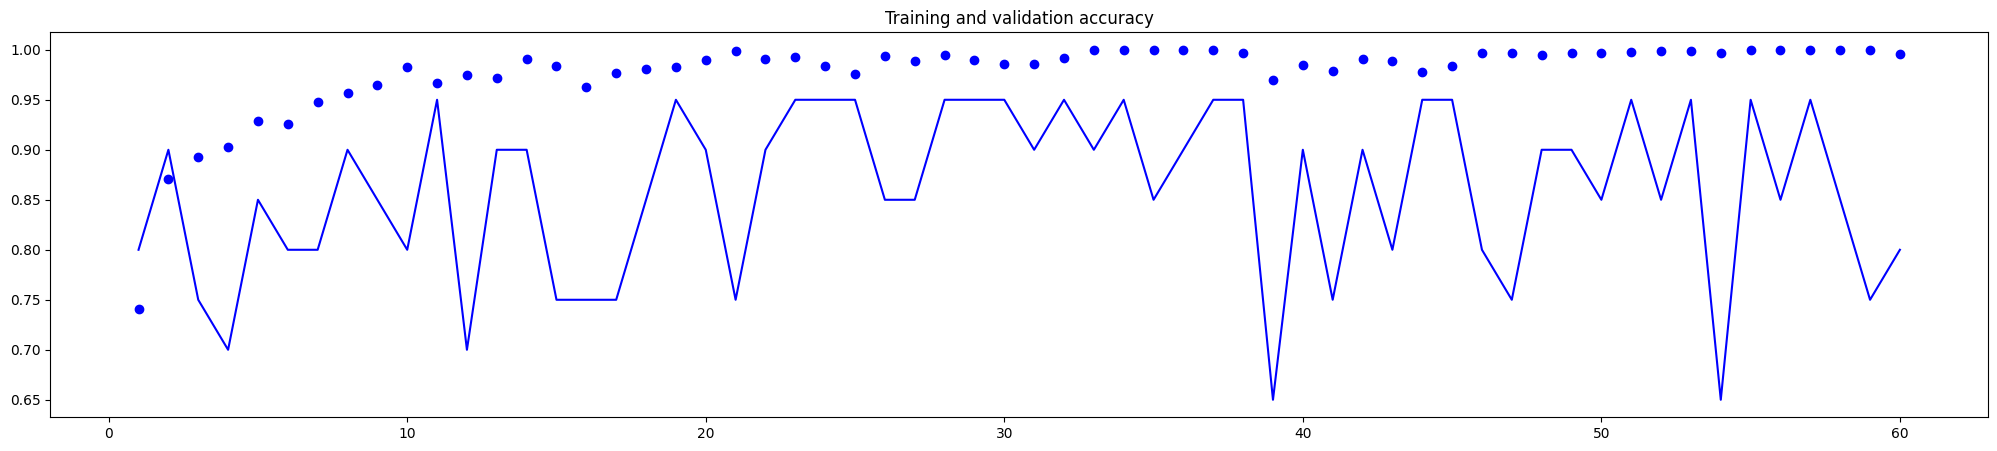

In [25]:
history1 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history1.items()}
plot_accuracy_from_history(history1)

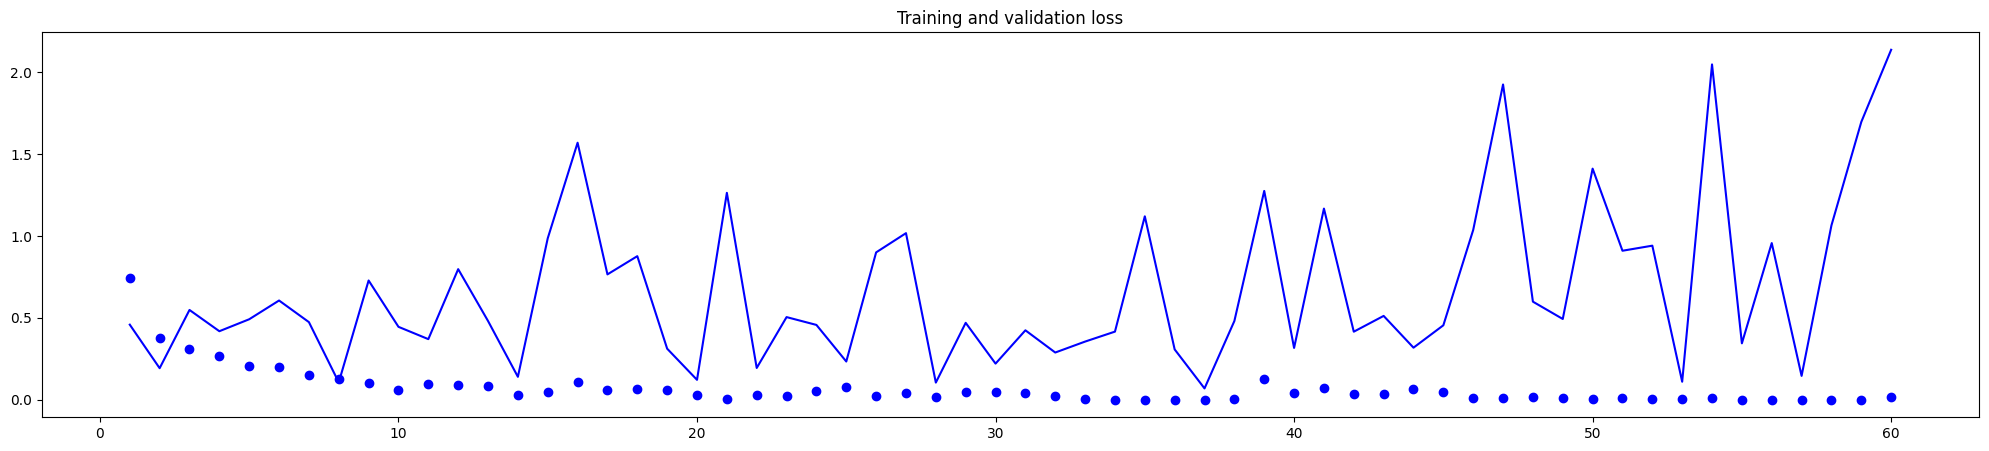

In [26]:
plot_loss_from_history(history1)


## <a id='toc2_3_'></a>[Fine-Tuning method (slower but with augmentation)](#toc0_)

### <a id='toc2_3_1_'></a>[Prepare Data](#toc0_)

In [17]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        # random horizontal flip
        transforms.RandomHorizontalFlip(),
        # random Linear Transformation
        transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    ]),
    'validation': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(150),
        transforms.CenterCrop(150),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Define data directories
data_dir: str = 'flowers/processed/'
image_datasets = {x: datasets.ImageFolder(root=data_dir+x, transform=data_transforms[x]) for x in ['train', 'validation', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=20, shuffle=True) for x in ['train', 'validation', 'test']}


In [18]:
COUNT_OF_CLASSES = len(image_datasets['train'].classes)
print(COUNT_OF_CLASSES)

5


### <a id='toc2_3_2_'></a>[Create model](#toc0_)

In [19]:
class ModelFineTuning(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters(): # freeze the ResNet layers
            param.requires_grad = False
        self.resnet.fc = nn.Identity()
        self.model = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, COUNT_OF_CLASSES),
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.model(x)
        return x
    
    
model2 = ModelFineTuning().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [20]:

# Training loop
accuracy_history: list = []
loss_history: list = []
val_accuracy_history: list = []
val_loss_history: list = []

for epoch in range(EPOCHS):
    
    model2.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloaders['train']):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # print(inputs.shape, labels.shape)
        # print(inputs)
        # print(labels)
        
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.cpu().item() * inputs.size(0)
        running_corrects += torch.sum(torch.argmax(outputs, 1) == labels)
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects / len(image_datasets['train'])
    accuracy_history.append(epoch_acc)
    loss_history.append(epoch_loss)

    # Validation loop
    model2.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['validation'], disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model2(inputs)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.cpu().item() * inputs.size(0)
            val_running_corrects += torch.sum(torch.argmax(outputs, 1) == labels)
    val_epoch_loss = val_running_loss / len(image_datasets['validation'])
    val_epoch_acc = val_running_corrects / len(image_datasets['validation'])
    val_accuracy_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
history2: dict = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
}
    
    

100%|██████████| 92/92 [00:08<00:00, 10.66it/s]


Epoch 1/60 Loss: 0.9701 Acc: 0.6270
Validation Loss: 0.5476 Acc: 0.8097


100%|██████████| 92/92 [00:08<00:00, 11.36it/s]


Epoch 2/60 Loss: 0.5812 Acc: 0.7832
Validation Loss: 0.4792 Acc: 0.7920


100%|██████████| 92/92 [00:09<00:00,  9.62it/s]


Epoch 3/60 Loss: 0.5322 Acc: 0.8110
Validation Loss: 0.3636 Acc: 0.8540


100%|██████████| 92/92 [00:08<00:00, 11.47it/s]


Epoch 4/60 Loss: 0.4871 Acc: 0.8301
Validation Loss: 0.3107 Acc: 0.8673


100%|██████████| 92/92 [00:08<00:00, 11.11it/s]


Epoch 5/60 Loss: 0.4184 Acc: 0.8465
Validation Loss: 0.2940 Acc: 0.8805


100%|██████████| 92/92 [00:08<00:00, 11.37it/s]


Epoch 6/60 Loss: 0.4328 Acc: 0.8591
Validation Loss: 0.3029 Acc: 0.8894


100%|██████████| 92/92 [00:09<00:00,  9.94it/s]


Epoch 7/60 Loss: 0.4143 Acc: 0.8564
Validation Loss: 0.3408 Acc: 0.8673


100%|██████████| 92/92 [00:08<00:00, 11.24it/s]


Epoch 8/60 Loss: 0.4290 Acc: 0.8438
Validation Loss: 0.3137 Acc: 0.8673


100%|██████████| 92/92 [00:08<00:00, 10.57it/s]


Epoch 9/60 Loss: 0.4034 Acc: 0.8536
Validation Loss: 0.3083 Acc: 0.8761


100%|██████████| 92/92 [00:08<00:00, 11.18it/s]


Epoch 10/60 Loss: 0.3867 Acc: 0.8618
Validation Loss: 0.3009 Acc: 0.8628


100%|██████████| 92/92 [00:08<00:00, 10.92it/s]


Epoch 11/60 Loss: 0.3716 Acc: 0.8733
Validation Loss: 0.2947 Acc: 0.8850


100%|██████████| 92/92 [00:09<00:00, 10.10it/s]


Epoch 12/60 Loss: 0.3750 Acc: 0.8646
Validation Loss: 0.2799 Acc: 0.8805


100%|██████████| 92/92 [00:08<00:00, 11.38it/s]


Epoch 13/60 Loss: 0.3492 Acc: 0.8760
Validation Loss: 0.3418 Acc: 0.8673


100%|██████████| 92/92 [00:09<00:00, 10.00it/s]


Epoch 14/60 Loss: 0.3184 Acc: 0.8804
Validation Loss: 0.2883 Acc: 0.8938


100%|██████████| 92/92 [00:08<00:00, 11.48it/s]


Epoch 15/60 Loss: 0.3162 Acc: 0.8848
Validation Loss: 0.3123 Acc: 0.8850


100%|██████████| 92/92 [00:08<00:00, 11.45it/s]


Epoch 16/60 Loss: 0.3438 Acc: 0.8760
Validation Loss: 0.2969 Acc: 0.8805


100%|██████████| 92/92 [00:08<00:00, 11.25it/s]


Epoch 17/60 Loss: 0.3291 Acc: 0.8793
Validation Loss: 0.2843 Acc: 0.8805


100%|██████████| 92/92 [00:10<00:00,  9.19it/s]


Epoch 18/60 Loss: 0.2990 Acc: 0.8886
Validation Loss: 0.2604 Acc: 0.8805


100%|██████████| 92/92 [00:09<00:00, 10.18it/s]


Epoch 19/60 Loss: 0.2878 Acc: 0.9044
Validation Loss: 0.2745 Acc: 0.8850


100%|██████████| 92/92 [00:08<00:00, 11.14it/s]


Epoch 20/60 Loss: 0.3026 Acc: 0.8859
Validation Loss: 0.3953 Acc: 0.8540


100%|██████████| 92/92 [00:09<00:00,  9.46it/s]


Epoch 21/60 Loss: 0.2796 Acc: 0.8995
Validation Loss: 0.2638 Acc: 0.8805


100%|██████████| 92/92 [00:08<00:00, 10.63it/s]


Epoch 22/60 Loss: 0.3302 Acc: 0.8897
Validation Loss: 0.3053 Acc: 0.8673


100%|██████████| 92/92 [00:08<00:00, 10.36it/s]


Epoch 23/60 Loss: 0.2615 Acc: 0.9001
Validation Loss: 0.3037 Acc: 0.8894


100%|██████████| 92/92 [00:08<00:00, 11.08it/s]


Epoch 24/60 Loss: 0.2901 Acc: 0.8946
Validation Loss: 0.2615 Acc: 0.8982


100%|██████████| 92/92 [00:07<00:00, 11.56it/s]


Epoch 25/60 Loss: 0.2826 Acc: 0.8984
Validation Loss: 0.2946 Acc: 0.8938


100%|██████████| 92/92 [00:07<00:00, 11.53it/s]


Epoch 26/60 Loss: 0.2487 Acc: 0.9148
Validation Loss: 0.3172 Acc: 0.8761


100%|██████████| 92/92 [00:07<00:00, 11.56it/s]


Epoch 27/60 Loss: 0.2634 Acc: 0.9088
Validation Loss: 0.2886 Acc: 0.8850


100%|██████████| 92/92 [00:10<00:00,  8.94it/s]


Epoch 28/60 Loss: 0.2346 Acc: 0.9148
Validation Loss: 0.2852 Acc: 0.8938


100%|██████████| 92/92 [00:09<00:00, 10.04it/s]


Epoch 29/60 Loss: 0.2417 Acc: 0.9153
Validation Loss: 0.3525 Acc: 0.8761


100%|██████████| 92/92 [00:08<00:00, 11.07it/s]


Epoch 30/60 Loss: 0.2589 Acc: 0.9066
Validation Loss: 0.3077 Acc: 0.8894


100%|██████████| 92/92 [00:08<00:00, 10.99it/s]


Epoch 31/60 Loss: 0.2381 Acc: 0.9137
Validation Loss: 0.3578 Acc: 0.8894


100%|██████████| 92/92 [00:09<00:00,  9.38it/s]


Epoch 32/60 Loss: 0.2094 Acc: 0.9219
Validation Loss: 0.3097 Acc: 0.9027


100%|██████████| 92/92 [00:09<00:00, 10.09it/s]


Epoch 33/60 Loss: 0.2631 Acc: 0.9137
Validation Loss: 0.2617 Acc: 0.9204


100%|██████████| 92/92 [00:09<00:00,  9.79it/s]


Epoch 34/60 Loss: 0.2192 Acc: 0.9164
Validation Loss: 0.3636 Acc: 0.8850


100%|██████████| 92/92 [00:09<00:00,  9.47it/s]


Epoch 35/60 Loss: 0.2067 Acc: 0.9192
Validation Loss: 0.4464 Acc: 0.8496


100%|██████████| 92/92 [00:08<00:00, 10.25it/s]


Epoch 36/60 Loss: 0.2132 Acc: 0.9170
Validation Loss: 0.3504 Acc: 0.8938


100%|██████████| 92/92 [00:08<00:00, 10.56it/s]


Epoch 37/60 Loss: 0.1958 Acc: 0.9306
Validation Loss: 0.3169 Acc: 0.8761


100%|██████████| 92/92 [00:09<00:00,  9.45it/s]


Epoch 38/60 Loss: 0.2365 Acc: 0.9186
Validation Loss: 0.3232 Acc: 0.8894


100%|██████████| 92/92 [00:08<00:00, 10.47it/s]


Epoch 39/60 Loss: 0.2317 Acc: 0.9214
Validation Loss: 0.3221 Acc: 0.8938


100%|██████████| 92/92 [00:08<00:00, 11.03it/s]


Epoch 40/60 Loss: 0.2260 Acc: 0.9159
Validation Loss: 0.3200 Acc: 0.8894


100%|██████████| 92/92 [00:09<00:00,  9.81it/s]


Epoch 41/60 Loss: 0.2113 Acc: 0.9268
Validation Loss: 0.2639 Acc: 0.9071


100%|██████████| 92/92 [00:10<00:00,  8.75it/s]


Epoch 42/60 Loss: 0.2055 Acc: 0.9312
Validation Loss: 0.3245 Acc: 0.9027


100%|██████████| 92/92 [00:09<00:00,  9.96it/s]


Epoch 43/60 Loss: 0.1925 Acc: 0.9301
Validation Loss: 0.3310 Acc: 0.8982


100%|██████████| 92/92 [00:09<00:00,  9.56it/s]


Epoch 44/60 Loss: 0.1927 Acc: 0.9274
Validation Loss: 0.2882 Acc: 0.8805


100%|██████████| 92/92 [00:10<00:00,  8.96it/s]


Epoch 45/60 Loss: 0.1573 Acc: 0.9459
Validation Loss: 0.2941 Acc: 0.9071


100%|██████████| 92/92 [00:08<00:00, 11.49it/s]


Epoch 46/60 Loss: 0.1742 Acc: 0.9388
Validation Loss: 0.3233 Acc: 0.9159


100%|██████████| 92/92 [00:08<00:00, 10.41it/s]


Epoch 47/60 Loss: 0.1751 Acc: 0.9405
Validation Loss: 0.3698 Acc: 0.8628


100%|██████████| 92/92 [00:09<00:00,  9.38it/s]


Epoch 48/60 Loss: 0.1912 Acc: 0.9377
Validation Loss: 0.3561 Acc: 0.8805


100%|██████████| 92/92 [00:08<00:00, 11.45it/s]


Epoch 49/60 Loss: 0.1672 Acc: 0.9421
Validation Loss: 0.3887 Acc: 0.8894


100%|██████████| 92/92 [00:07<00:00, 11.92it/s]


Epoch 50/60 Loss: 0.1998 Acc: 0.9290
Validation Loss: 0.3465 Acc: 0.8761


100%|██████████| 92/92 [00:08<00:00, 11.45it/s]


Epoch 51/60 Loss: 0.1569 Acc: 0.9427
Validation Loss: 0.3919 Acc: 0.8717


100%|██████████| 92/92 [00:09<00:00,  9.77it/s]


Epoch 52/60 Loss: 0.1744 Acc: 0.9421
Validation Loss: 0.3524 Acc: 0.8982


100%|██████████| 92/92 [00:07<00:00, 11.89it/s]


Epoch 53/60 Loss: 0.1514 Acc: 0.9399
Validation Loss: 0.3171 Acc: 0.8805


100%|██████████| 92/92 [00:07<00:00, 11.57it/s]


Epoch 54/60 Loss: 0.1818 Acc: 0.9361
Validation Loss: 0.4277 Acc: 0.8540


100%|██████████| 92/92 [00:08<00:00, 10.98it/s]


Epoch 55/60 Loss: 0.1723 Acc: 0.9394
Validation Loss: 0.3673 Acc: 0.8938


100%|██████████| 92/92 [00:10<00:00,  8.82it/s]


Epoch 56/60 Loss: 0.1541 Acc: 0.9470
Validation Loss: 0.3100 Acc: 0.9115


100%|██████████| 92/92 [00:07<00:00, 11.96it/s]


Epoch 57/60 Loss: 0.1532 Acc: 0.9498
Validation Loss: 0.3650 Acc: 0.8894


100%|██████████| 92/92 [00:08<00:00, 11.47it/s]


Epoch 58/60 Loss: 0.1588 Acc: 0.9437
Validation Loss: 0.3954 Acc: 0.8717


100%|██████████| 92/92 [00:09<00:00, 10.00it/s]


Epoch 59/60 Loss: 0.1542 Acc: 0.9432
Validation Loss: 0.3874 Acc: 0.8717


100%|██████████| 92/92 [00:08<00:00, 11.28it/s]


Epoch 60/60 Loss: 0.1622 Acc: 0.9476
Validation Loss: 0.3642 Acc: 0.8982


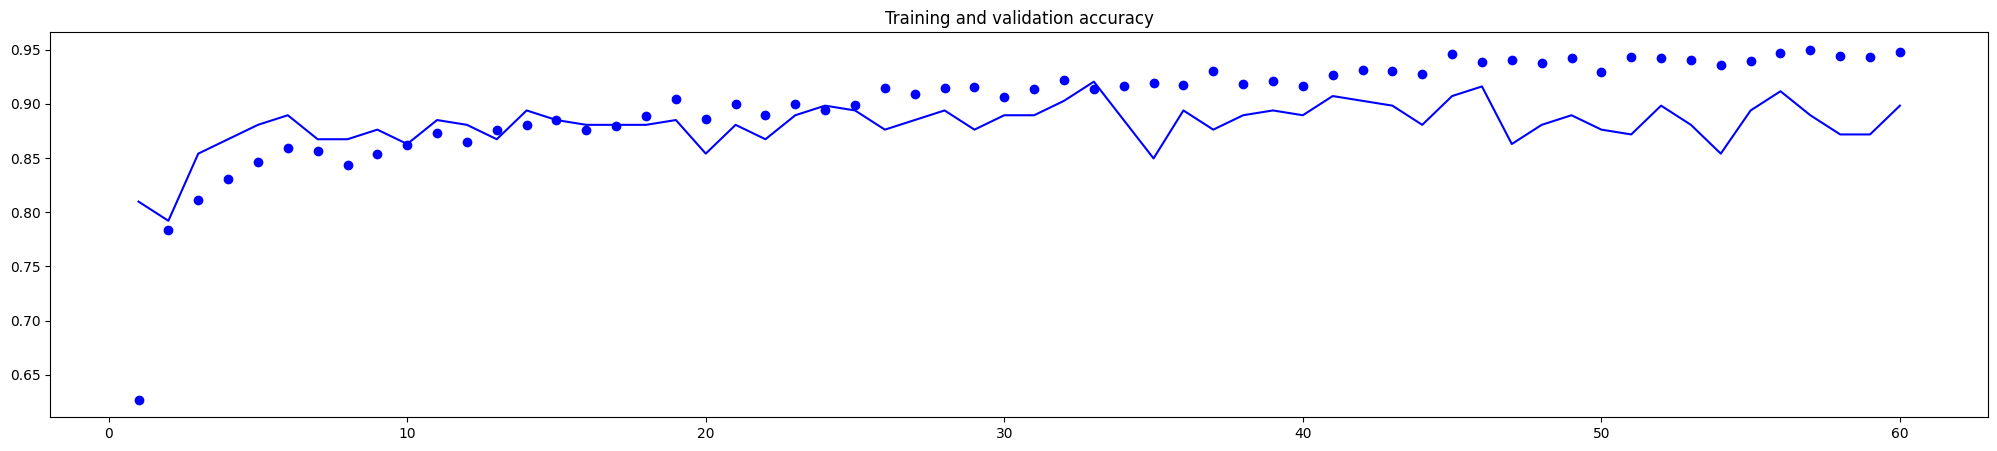

In [27]:
history2 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history2.items()}
plot_accuracy_from_history(history2)

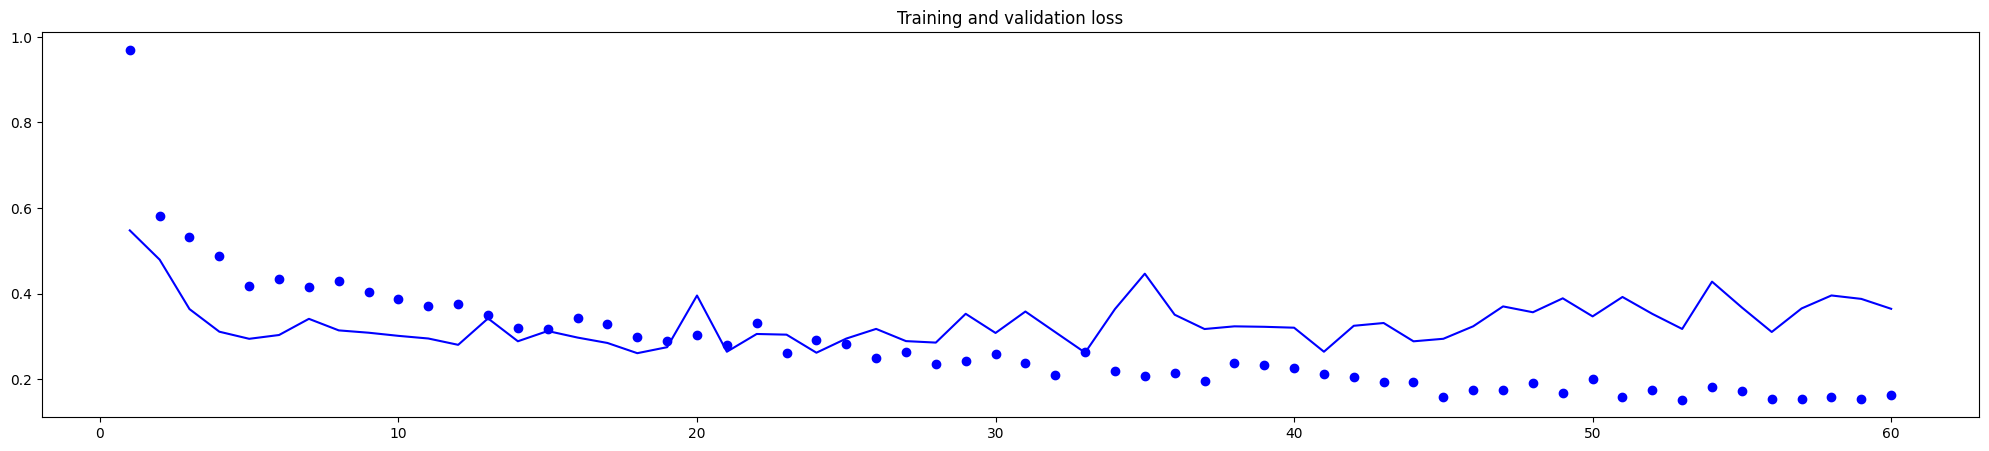

In [28]:
plot_loss_from_history(history2)

## <a id='toc2_4_'></a>[Tuning Method (unfreeze few layers from ResNet)](#toc0_)

### <a id='toc2_4_1_'></a>[Model](#toc0_)

In [22]:
class ModelTuning(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters(): # freeze the ResNet layers
            param.requires_grad = False
        for param in self.resnet.layer4.parameters(): # unfreeze the last layer
            param.requires_grad = True
        self.resnet.fc = nn.Identity()
        self.model = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, COUNT_OF_CLASSES),
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.model(x)
        return x
    
    
model3 = ModelTuning().to(device)
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

In [23]:
accuracy_history: list = []
loss_history: list = []
val_accuracy_history: list = []
val_loss_history: list = []

for epoch in range(EPOCHS):
    model3.train()
    
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(dataloaders['train']):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model3(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.cpu().item() * inputs.size(0)
        running_corrects += torch.sum(torch.argmax(outputs, 1) == labels)
    epoch_loss = running_loss / len(image_datasets['train'])
    epoch_acc = running_corrects / len(image_datasets['train'])
    accuracy_history.append(epoch_acc)
    loss_history.append(epoch_loss)

    # Validation loop
    model3.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['validation'], disable=True):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model3(inputs)
            val_loss = criterion(outputs, labels.long())
            val_running_loss += val_loss.cpu().item() * inputs.size(0)
            val_running_corrects += torch.sum(torch.argmax(outputs, 1) == labels)
    val_epoch_loss = val_running_loss / len(image_datasets['validation'])
    val_epoch_acc = val_running_corrects / len(image_datasets['validation'])
    val_accuracy_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)

    print(f'Epoch {epoch+1}/{EPOCHS} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
    
history3: dict = {
        'accuracy': accuracy_history,
        'loss': loss_history,
        'val_accuracy': val_accuracy_history,
        'val_loss': val_loss_history
    }

100%|██████████| 92/92 [00:08<00:00, 10.22it/s]


Epoch 1/60 Loss: 0.6768 Acc: 0.7723
Validation Loss: 0.3086 Acc: 0.9071


100%|██████████| 92/92 [00:09<00:00,  9.73it/s]


Epoch 2/60 Loss: 0.4175 Acc: 0.8651
Validation Loss: 0.3687 Acc: 0.8628


100%|██████████| 92/92 [00:10<00:00,  8.93it/s]


Epoch 3/60 Loss: 0.3547 Acc: 0.8831
Validation Loss: 0.3004 Acc: 0.8982


100%|██████████| 92/92 [00:08<00:00, 10.75it/s]


Epoch 4/60 Loss: 0.3101 Acc: 0.9115
Validation Loss: 0.3435 Acc: 0.8894


100%|██████████| 92/92 [00:08<00:00, 10.80it/s]


Epoch 5/60 Loss: 0.2464 Acc: 0.9224
Validation Loss: 0.3247 Acc: 0.8761


100%|██████████| 92/92 [00:10<00:00,  9.16it/s]


Epoch 6/60 Loss: 0.2439 Acc: 0.9224
Validation Loss: 0.2855 Acc: 0.9115


100%|██████████| 92/92 [00:08<00:00, 10.41it/s]


Epoch 7/60 Loss: 0.2053 Acc: 0.9372
Validation Loss: 0.3049 Acc: 0.8982


100%|██████████| 92/92 [00:08<00:00, 10.40it/s]


Epoch 8/60 Loss: 0.1937 Acc: 0.9465
Validation Loss: 0.3528 Acc: 0.8850


100%|██████████| 92/92 [00:08<00:00, 10.47it/s]


Epoch 9/60 Loss: 0.1916 Acc: 0.9459
Validation Loss: 0.2364 Acc: 0.9381


100%|██████████| 92/92 [00:09<00:00, 10.17it/s]


Epoch 10/60 Loss: 0.1416 Acc: 0.9552
Validation Loss: 0.3418 Acc: 0.8761


100%|██████████| 92/92 [00:10<00:00,  8.46it/s]


Epoch 11/60 Loss: 0.1180 Acc: 0.9612
Validation Loss: 0.2718 Acc: 0.9071


100%|██████████| 92/92 [00:09<00:00,  9.59it/s]


Epoch 12/60 Loss: 0.1242 Acc: 0.9650
Validation Loss: 0.3758 Acc: 0.9115


100%|██████████| 92/92 [00:08<00:00, 10.30it/s]


Epoch 13/60 Loss: 0.1364 Acc: 0.9645
Validation Loss: 0.2751 Acc: 0.9204


100%|██████████| 92/92 [00:10<00:00,  8.97it/s]


Epoch 14/60 Loss: 0.1252 Acc: 0.9607
Validation Loss: 0.2171 Acc: 0.9204


100%|██████████| 92/92 [00:09<00:00, 10.13it/s]


Epoch 15/60 Loss: 0.1101 Acc: 0.9656
Validation Loss: 0.2768 Acc: 0.9071


100%|██████████| 92/92 [00:09<00:00, 10.07it/s]


Epoch 16/60 Loss: 0.0955 Acc: 0.9623
Validation Loss: 0.3151 Acc: 0.9248


100%|██████████| 92/92 [00:09<00:00,  9.87it/s]


Epoch 17/60 Loss: 0.1056 Acc: 0.9678
Validation Loss: 0.2504 Acc: 0.9115


100%|██████████| 92/92 [00:09<00:00,  9.82it/s]


Epoch 18/60 Loss: 0.1007 Acc: 0.9716
Validation Loss: 0.2422 Acc: 0.9292


100%|██████████| 92/92 [00:08<00:00, 10.68it/s]


Epoch 19/60 Loss: 0.0860 Acc: 0.9738
Validation Loss: 0.2423 Acc: 0.9159


100%|██████████| 92/92 [00:09<00:00,  9.45it/s]


Epoch 20/60 Loss: 0.1009 Acc: 0.9661
Validation Loss: 0.2831 Acc: 0.9248


100%|██████████| 92/92 [00:10<00:00,  8.84it/s]


Epoch 21/60 Loss: 0.0875 Acc: 0.9754
Validation Loss: 0.2613 Acc: 0.9336


100%|██████████| 92/92 [00:08<00:00, 10.78it/s]


Epoch 22/60 Loss: 0.0602 Acc: 0.9847
Validation Loss: 0.4843 Acc: 0.8938


100%|██████████| 92/92 [00:08<00:00, 10.31it/s]


Epoch 23/60 Loss: 0.0835 Acc: 0.9749
Validation Loss: 0.2215 Acc: 0.9425


100%|██████████| 92/92 [00:10<00:00,  8.52it/s]


Epoch 24/60 Loss: 0.0717 Acc: 0.9760
Validation Loss: 0.3893 Acc: 0.9292


100%|██████████| 92/92 [00:08<00:00, 10.50it/s]


Epoch 25/60 Loss: 0.0683 Acc: 0.9792
Validation Loss: 0.2053 Acc: 0.9469


100%|██████████| 92/92 [00:08<00:00, 10.23it/s]


Epoch 26/60 Loss: 0.0705 Acc: 0.9782
Validation Loss: 0.4459 Acc: 0.9115


100%|██████████| 92/92 [00:10<00:00,  9.16it/s]


Epoch 27/60 Loss: 0.0787 Acc: 0.9754
Validation Loss: 0.3412 Acc: 0.9071


100%|██████████| 92/92 [00:08<00:00, 10.27it/s]


Epoch 28/60 Loss: 0.0283 Acc: 0.9918
Validation Loss: 0.2417 Acc: 0.9292


100%|██████████| 92/92 [00:08<00:00, 10.40it/s]


Epoch 29/60 Loss: 0.0803 Acc: 0.9792
Validation Loss: 0.2759 Acc: 0.9425


100%|██████████| 92/92 [00:09<00:00,  9.84it/s]


Epoch 30/60 Loss: 0.0949 Acc: 0.9743
Validation Loss: 0.1941 Acc: 0.9159


100%|██████████| 92/92 [00:10<00:00,  9.05it/s]


Epoch 31/60 Loss: 0.0745 Acc: 0.9787
Validation Loss: 0.2532 Acc: 0.9381


100%|██████████| 92/92 [00:08<00:00, 10.39it/s]


Epoch 32/60 Loss: 0.0418 Acc: 0.9885
Validation Loss: 0.3031 Acc: 0.9292


100%|██████████| 92/92 [00:08<00:00, 10.23it/s]


Epoch 33/60 Loss: 0.0522 Acc: 0.9820
Validation Loss: 0.2234 Acc: 0.9513


100%|██████████| 92/92 [00:10<00:00,  9.12it/s]


Epoch 34/60 Loss: 0.0415 Acc: 0.9891
Validation Loss: 0.3369 Acc: 0.9248


100%|██████████| 92/92 [00:08<00:00, 10.50it/s]


Epoch 35/60 Loss: 0.0715 Acc: 0.9825
Validation Loss: 0.2226 Acc: 0.9513


100%|██████████| 92/92 [00:10<00:00,  8.58it/s]


Epoch 36/60 Loss: 0.0468 Acc: 0.9863
Validation Loss: 0.2681 Acc: 0.9292


100%|██████████| 92/92 [00:10<00:00,  8.68it/s]


Epoch 37/60 Loss: 0.0813 Acc: 0.9809
Validation Loss: 0.2013 Acc: 0.9469


100%|██████████| 92/92 [00:08<00:00, 10.30it/s]


Epoch 38/60 Loss: 0.0392 Acc: 0.9885
Validation Loss: 0.2211 Acc: 0.9513


100%|██████████| 92/92 [00:09<00:00, 10.04it/s]


Epoch 39/60 Loss: 0.0601 Acc: 0.9820
Validation Loss: 0.2006 Acc: 0.9558


100%|██████████| 92/92 [00:09<00:00,  9.25it/s]


Epoch 40/60 Loss: 0.0584 Acc: 0.9825
Validation Loss: 0.2875 Acc: 0.9292


100%|██████████| 92/92 [00:08<00:00, 10.53it/s]


Epoch 41/60 Loss: 0.0645 Acc: 0.9842
Validation Loss: 0.1438 Acc: 0.9469


100%|██████████| 92/92 [00:08<00:00, 10.66it/s]


Epoch 42/60 Loss: 0.0401 Acc: 0.9874
Validation Loss: 0.2045 Acc: 0.9425


100%|██████████| 92/92 [00:08<00:00, 10.38it/s]


Epoch 43/60 Loss: 0.0321 Acc: 0.9896
Validation Loss: 0.1548 Acc: 0.9469


100%|██████████| 92/92 [00:09<00:00,  9.27it/s]


Epoch 44/60 Loss: 0.0252 Acc: 0.9940
Validation Loss: 0.1657 Acc: 0.9690


100%|██████████| 92/92 [00:08<00:00, 10.43it/s]


Epoch 45/60 Loss: 0.0318 Acc: 0.9934
Validation Loss: 0.1478 Acc: 0.9425


100%|██████████| 92/92 [00:08<00:00, 10.39it/s]


Epoch 46/60 Loss: 0.0261 Acc: 0.9918
Validation Loss: 0.1554 Acc: 0.9558


100%|██████████| 92/92 [00:09<00:00,  9.70it/s]


Epoch 47/60 Loss: 0.0372 Acc: 0.9896
Validation Loss: 0.2129 Acc: 0.9513


100%|██████████| 92/92 [00:08<00:00, 10.46it/s]


Epoch 48/60 Loss: 0.0347 Acc: 0.9896
Validation Loss: 0.3550 Acc: 0.9204


100%|██████████| 92/92 [00:08<00:00, 11.16it/s]


Epoch 49/60 Loss: 0.0297 Acc: 0.9902
Validation Loss: 0.2100 Acc: 0.9513


100%|██████████| 92/92 [00:08<00:00, 10.38it/s]


Epoch 50/60 Loss: 0.0497 Acc: 0.9842
Validation Loss: 0.1784 Acc: 0.9425


100%|██████████| 92/92 [00:09<00:00,  9.30it/s]


Epoch 51/60 Loss: 0.0425 Acc: 0.9831
Validation Loss: 0.1756 Acc: 0.9513


100%|██████████| 92/92 [00:08<00:00, 10.59it/s]


Epoch 52/60 Loss: 0.0387 Acc: 0.9896
Validation Loss: 0.2836 Acc: 0.9336


100%|██████████| 92/92 [00:08<00:00, 10.30it/s]


Epoch 53/60 Loss: 0.0665 Acc: 0.9825
Validation Loss: 0.2095 Acc: 0.9381


100%|██████████| 92/92 [00:09<00:00,  9.81it/s]


Epoch 54/60 Loss: 0.0488 Acc: 0.9847
Validation Loss: 0.1804 Acc: 0.9513


100%|██████████| 92/92 [00:08<00:00, 10.42it/s]


Epoch 55/60 Loss: 0.0333 Acc: 0.9907
Validation Loss: 0.2618 Acc: 0.9381


100%|██████████| 92/92 [00:08<00:00, 10.72it/s]


Epoch 56/60 Loss: 0.0288 Acc: 0.9896
Validation Loss: 0.2266 Acc: 0.9513


100%|██████████| 92/92 [00:08<00:00, 10.50it/s]


Epoch 57/60 Loss: 0.0338 Acc: 0.9896
Validation Loss: 0.2465 Acc: 0.9292


100%|██████████| 92/92 [00:08<00:00, 10.55it/s]


Epoch 58/60 Loss: 0.0368 Acc: 0.9858
Validation Loss: 0.3759 Acc: 0.9248


100%|██████████| 92/92 [00:08<00:00, 10.62it/s]


Epoch 59/60 Loss: 0.0290 Acc: 0.9929
Validation Loss: 0.4106 Acc: 0.9248


100%|██████████| 92/92 [00:08<00:00, 10.51it/s]


Epoch 60/60 Loss: 0.0424 Acc: 0.9913
Validation Loss: 0.2481 Acc: 0.9425


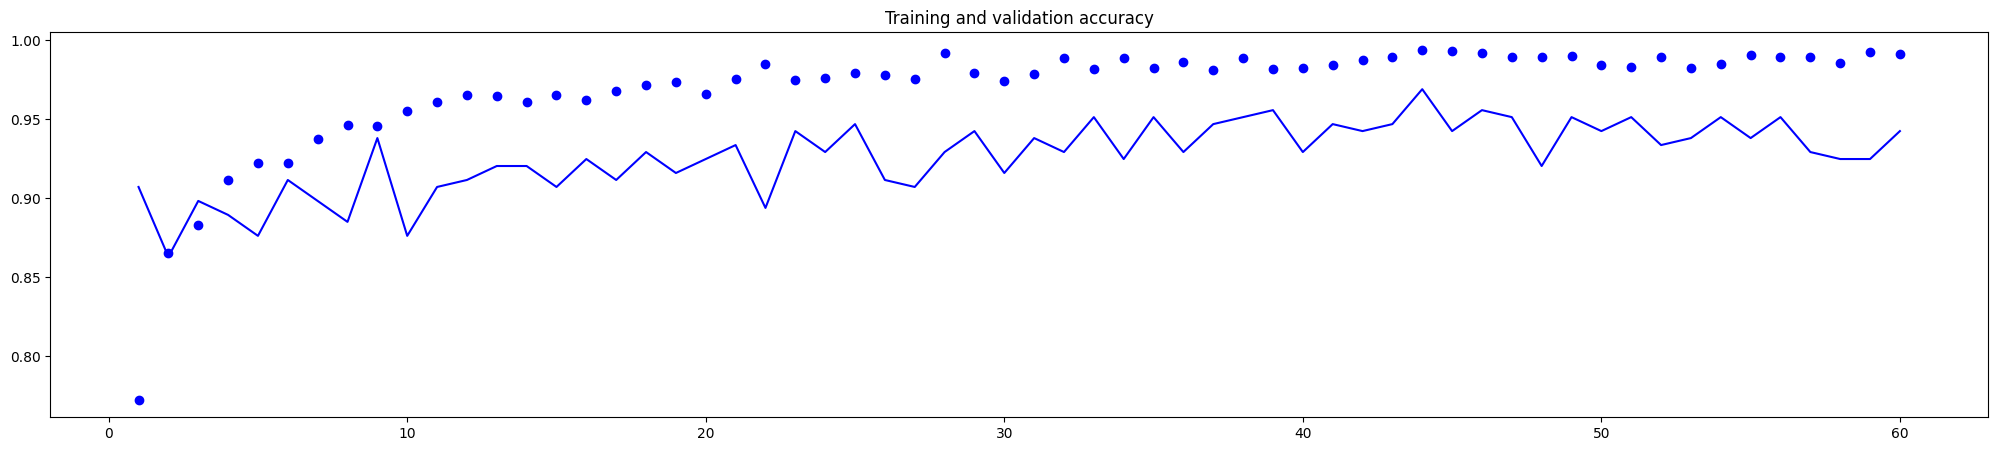

In [29]:
history3 = {k: [v.cpu().numpy() if isinstance(v, torch.Tensor) else v for v in vs] for k, vs in history3.items()}
plot_accuracy_from_history(history3)

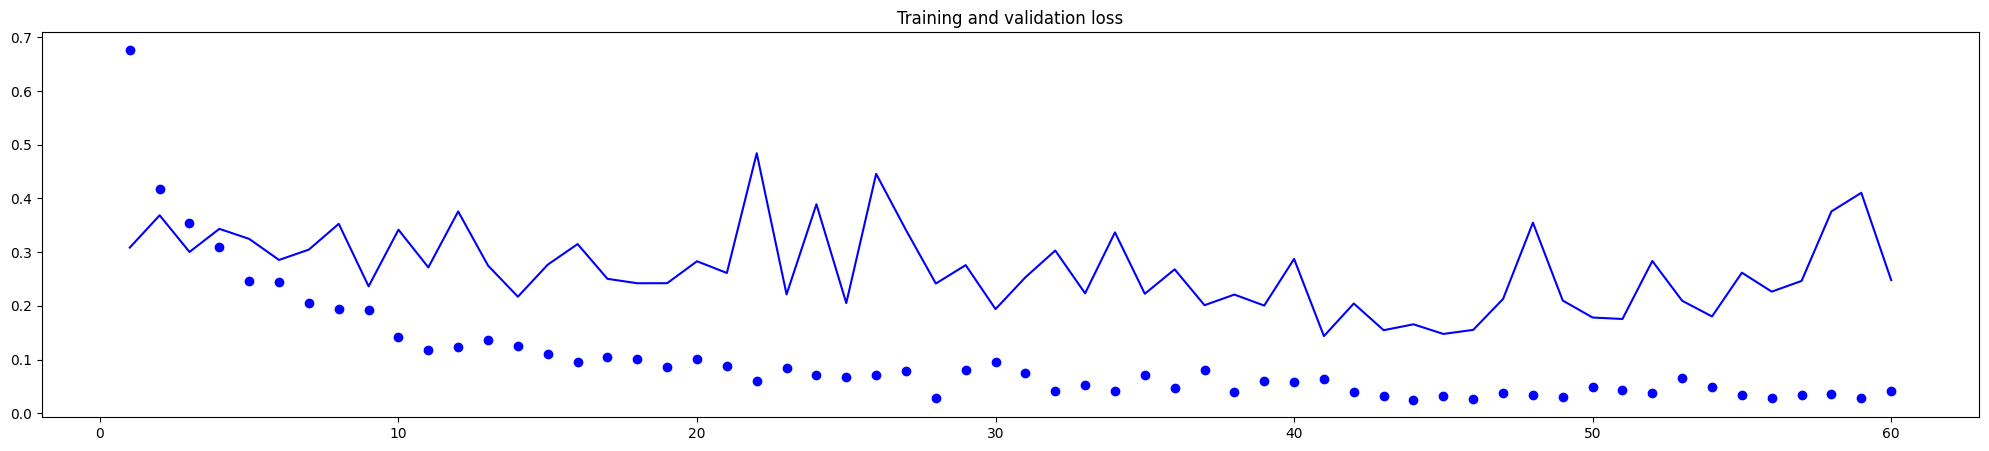

In [30]:
plot_loss_from_history(history3)


# <a id='toc3_'></a>[Conclusion](#toc0_)
In this notebook, I took the knowledge I gained from the base task and applied it to the Flowers Contest dataset. The results in comparison to previously used CNN were much more accurate and scored much higher.